# 沪深港通资金流向深度分析
## Stock Connect Money Flow Analysis
本脚本从两个视角分析沪深港通资金流向数据:
1. **A股投资者视角** - 关注市场情绪、投资机会、风险预警
2. **量化投资者视角** - 关注统计因子、模型构建、回测信号


## 第一部分: 环境配置与数据加载


In [62]:
# =============================================================================
# 导入必要的库
# =============================================================================
import duckdb                    # 用于连接DuckDB数据库
import pandas as pd              # 数据处理核心库
import numpy as np               # 数值计算库
import matplotlib.pyplot as plt  # 可视化库
from scipy import stats          # 统计分析库
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示 (Setting Chinese font display)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 库导入成功！Libraries imported successfully!")


✅ 库导入成功！Libraries imported successfully!


In [63]:
# =============================================================================
# 连接DuckDB数据库并加载数据
# Connect to DuckDB and load data
# =============================================================================

# 数据库路径
DB_PATH = '/Users/robert/Developer/DuckDB/tushare_duck_moneyflow.db'

# 使用只读模式连接数据库，防止意外修改
conn = duckdb.connect(DB_PATH, read_only=True)

# 查询所有数据
query = "SELECT * FROM moneyflow_hsgt where trade_date >= '20241001'"
df = conn.execute(query).fetchdf()

# 关闭连接
conn.close()

print(f"✅ 数据加载成功！共 {len(df)} 行数据")
print("\n📊 数据基本信息:")
df.info()


✅ 数据加载成功！共 309 行数据

📊 数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade_date   309 non-null    object 
 1   ggt_ss       309 non-null    float64
 2   ggt_sz       309 non-null    float64
 3   hgt          309 non-null    float64
 4   sgt          309 non-null    float64
 5   north_money  309 non-null    float64
 6   south_money  309 non-null    float64
dtypes: float64(6), object(1)
memory usage: 17.0+ KB


In [64]:
# =============================================================================
# 数据预处理
# Data Preprocessing
# =============================================================================

# 将日期列转换为datetime格式，方便后续时间序列分析
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')

# 按日期排序（非常重要！确保时间序列的顺序正确）
df = df.sort_values('trade_date').reset_index(drop=True)

# 处理缺失值：早期某些通道未开通，用0填充
# ggt_sz (深港通-港股通深) 2016年12月才开通
# sgt (深股通) 2016年12月才开通
df_filled = df.fillna(0)

print("✅ 数据预处理完成！")
print(f"\n📅 数据时间范围: {df['trade_date'].min()} 至 {df['trade_date'].max()}")
print("\n📋 前5行数据预览:")
display(df.head())
print("\n📋 后5行数据预览:")
display(df.tail())


✅ 数据预处理完成！

📅 数据时间范围: 2024-10-08 00:00:00 至 2026-01-22 00:00:00

📋 前5行数据预览:


,trade_date,ggt_ss,ggt_sz,hgt,sgt,north_money,south_money
0,2024-10-08,18330.21,15625.50,273897.03,236204.26,510101.29,33955.72
1,2024-10-09,18299.23,15650.10,205478.60,187975.33,393453.93,33949.33
2,2024-10-10,18340.11,15714.79,159687.68,141431.92,301119.60,34054.90
3,2024-10-14,18415.64,15760.96,130732.08,122039.12,252771.20,34176.60
4,2024-10-15,18465.29,15796.75,111971.32,117832.97,229804.29,34262.04



📋 后5行数据预览:


,trade_date,ggt_ss,ggt_sz,hgt,sgt,north_money,south_money
304,2026-01-16,28393.89,23059.86,166031.49,200541.01,366572.50,51453.74
305,2026-01-19,28424.30,23052.36,147608.62,176161.47,323770.09,51476.66
306,2026-01-20,28458.74,23054.54,158832.38,184935.74,343768.12,51513.28
307,2026-01-21,28536.64,23115.95,154231.36,166984.02,321215.38,51652.58
308,2026-01-22,28564.39,23140.59,155536.95,175540.19,331077.14,51704.98


In [65]:
# =============================================================================
# 数据列说明 (Column Descriptions)
# =============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                           数据列说明 (Column Descriptions)                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ trade_date  - 交易日期                                                       ║
║ ggt_ss      - 港股通(沪) - 上海投资者买港股 (累计净流入)                       ║
║ ggt_sz      - 港股通(深) - 深圳投资者买港股 (累计净流入, 2016年12月开通)        ║
║ hgt         - 沪股通 - 香港投资者买沪市A股 (累计净流入)                        ║
║ sgt         - 深股通 - 香港投资者买深市A股 (累计净流入, 2016年12月开通)         ║
║ north_money - 北向资金 = hgt + sgt (外资流入A股)                              ║
║ south_money - 南向资金 = ggt_ss + ggt_sz (内资流入港股)                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

💡 关键理解:
• 北向资金(north_money): 外资对A股的态度，常被视为"聪明钱"
• 南向资金(south_money): 内地投资者对港股的配置需求
• 数据为累计值，需要计算差分(diff)得到每日净流入
""")



╔══════════════════════════════════════════════════════════════════════════════╗
║                           数据列说明 (Column Descriptions)                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ trade_date  - 交易日期                                                       ║
║ ggt_ss      - 港股通(沪) - 上海投资者买港股 (累计净流入)                       ║
║ ggt_sz      - 港股通(深) - 深圳投资者买港股 (累计净流入, 2016年12月开通)        ║
║ hgt         - 沪股通 - 香港投资者买沪市A股 (累计净流入)                        ║
║ sgt         - 深股通 - 香港投资者买深市A股 (累计净流入, 2016年12月开通)         ║
║ north_money - 北向资金 = hgt + sgt (外资流入A股)                              ║
║ south_money - 南向资金 = ggt_ss + ggt_sz (内资流入港股)                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

💡 关键理解:
• 北向资金(north_money): 外资对A股的态度，常被视为"聪明钱"
• 南向资金(south_money): 内地投资者对港股的配置需求
• 数据为累计值，需要计算差分(diff)得到每日净流入



In [67]:
# =============================================================================
# ⚡ 关键分界点: 924行情 (2024-09-24)
# CRITICAL BREAKPOINT: "924 Rally" (September 24, 2024)
# =============================================================================

# 2024年9月24日是A股历史性的政策刺激日
# 当天央行、金融监管总局、证监会联合发布重磅利好政策
# 导致北向资金出现前所未有的大规模涌入

BREAKPOINT_DATE = pd.Timestamp('2024-09-24')

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║              ⚡ 关键分界点: 924行情 (2024-09-24)                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  2024年9月24日，央行、金融监管总局、证监会联合发布重磅利好政策!               ║
║  • 降准降息                                                                  ║
║  • 降低存量房贷利率                                                          ║
║  • 创设股票市场支持工具                                                       ║
║  此后北向资金流入规模发生结构性变化，数据分析需以此为分界点!                   ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# 创建两个分段数据集
if df['trade_date'].min() < BREAKPOINT_DATE:
    df_before_924 = df[df['trade_date'] < BREAKPOINT_DATE].copy()  # 924之前
    df_after_924 = df[df['trade_date'] >= BREAKPOINT_DATE].copy()  # 924之后(含)

    print(f"📊 数据分段统计:")
    print(f"   • 924之前: {len(df_before_924)} 个交易日 ({df_before_924['trade_date'].min().strftime('%Y-%m-%d')} 至 {df_before_924['trade_date'].max().strftime('%Y-%m-%d')})")
    print(f"   • 924之后: {len(df_after_924)} 个交易日 ({df_after_924['trade_date'].min().strftime('%Y-%m-%d')} 至 {df_after_924['trade_date'].max().strftime('%Y-%m-%d')})")

else:
    print("数据范围未覆盖924行情，无法进行分段分析")
    df_after_924 = df[df['trade_date'] >= BREAKPOINT_DATE].copy()  # 924之后(含)
    print(f"   • 924之后: {len(df_after_924)} 个交易日 ({df_after_924['trade_date'].min().strftime('%Y-%m-%d')} 至 {df_after_924['trade_date'].max().strftime('%Y-%m-%d')})")


╔══════════════════════════════════════════════════════════════════════════════╗
║              ⚡ 关键分界点: 924行情 (2024-09-24)                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  2024年9月24日，央行、金融监管总局、证监会联合发布重磅利好政策!               ║
║  • 降准降息                                                                  ║
║  • 降低存量房贷利率                                                          ║
║  • 创设股票市场支持工具                                                       ║
║  此后北向资金流入规模发生结构性变化，数据分析需以此为分界点!                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

数据范围未覆盖924行情，无法进行分段分析
   • 924之后: 309 个交易日 (2024-10-08 至 2026-01-22)


---
# 第二部分: A股投资者视角分析
## Part 2: A-Share Investor Perspective


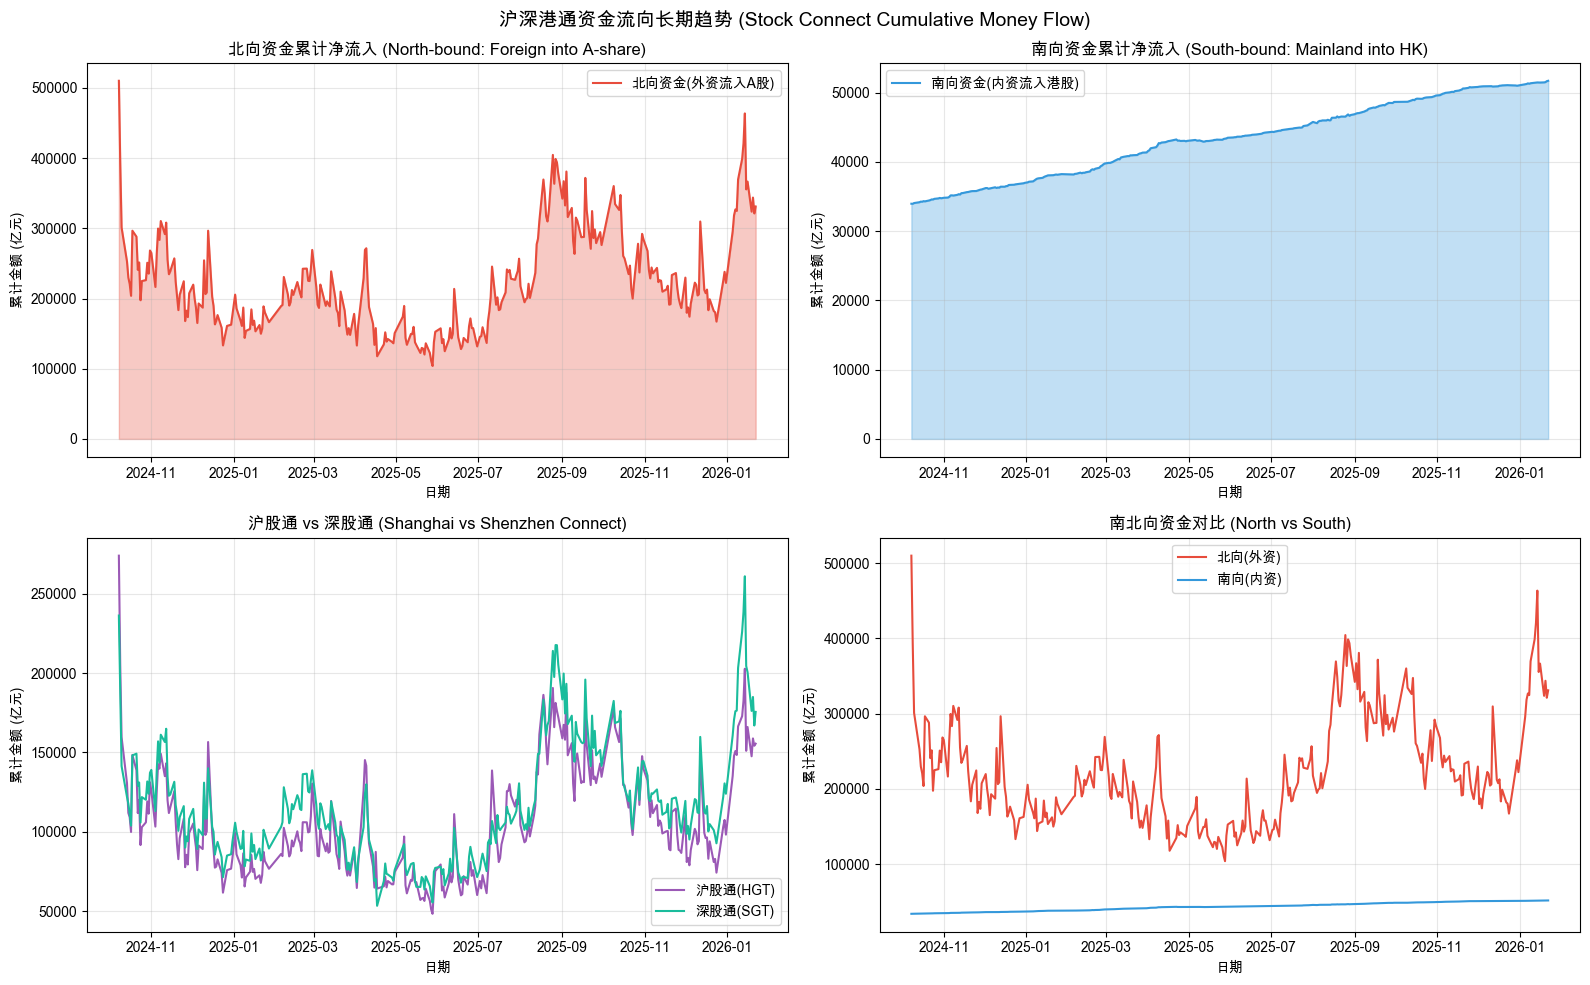

📈 趋势分析要点:
   • 北向资金最新累计: 331077.14 亿元
   • 南向资金最新累计: 51704.98 亿元
   • 北向/南向比率: 6.40


In [68]:
# =============================================================================
# 2.1 时间趋势维度 - 资金流向长期趋势
# Time Trend Dimension
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('沪深港通资金流向长期趋势 (Stock Connect Cumulative Money Flow)', fontsize=14, fontweight='bold')

# 北向资金累计趋势
ax1 = axes[0, 0]
ax1.plot(df['trade_date'], df['north_money'], color='#E74C3C', linewidth=1.5, label='北向资金(外资流入A股)')
ax1.fill_between(df['trade_date'], 0, df['north_money'], alpha=0.3, color='#E74C3C')
ax1.set_title('北向资金累计净流入 (North-bound: Foreign into A-share)')
ax1.set_xlabel('日期')
ax1.set_ylabel('累计金额 (亿元)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 南向资金累计趋势
ax2 = axes[0, 1]
ax2.plot(df['trade_date'], df['south_money'], color='#3498DB', linewidth=1.5, label='南向资金(内资流入港股)')
ax2.fill_between(df['trade_date'], 0, df['south_money'], alpha=0.3, color='#3498DB')
ax2.set_title('南向资金累计净流入 (South-bound: Mainland into HK)')
ax2.set_xlabel('日期')
ax2.set_ylabel('累计金额 (亿元)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 沪股通 vs 深股通对比
ax3 = axes[1, 0]
ax3.plot(df['trade_date'], df['hgt'], color='#9B59B6', linewidth=1.5, label='沪股通(HGT)')
ax3.plot(df['trade_date'], df['sgt'], color='#1ABC9C', linewidth=1.5, label='深股通(SGT)')
ax3.set_title('沪股通 vs 深股通 (Shanghai vs Shenzhen Connect)')
ax3.set_xlabel('日期')
ax3.set_ylabel('累计金额 (亿元)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 南北向对比
ax4 = axes[1, 1]
ax4.plot(df['trade_date'], df['north_money'], color='#E74C3C', linewidth=1.5, label='北向(外资)')
ax4.plot(df['trade_date'], df['south_money'], color='#3498DB', linewidth=1.5, label='南向(内资)')
ax4.set_title('南北向资金对比 (North vs South)')
ax4.set_xlabel('日期')
ax4.set_ylabel('累计金额 (亿元)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 趋势分析要点:")
print(f"   • 北向资金最新累计: {df['north_money'].iloc[-1]:.2f} 亿元")
print(f"   • 南向资金最新累计: {df['south_money'].iloc[-1]:.2f} 亿元")
print(f"   • 北向/南向比率: {df['north_money'].iloc[-1]/df['south_money'].iloc[-1]:.2f}")


In [69]:
# =============================================================================
# 2.2 计算每日净流入 (Daily Net Inflow)
# =============================================================================

# 使用diff()计算每日变化量，这是最关键的一步！
df['north_daily'] = df['north_money'].diff()  # 北向每日净流入
df['south_daily'] = df['south_money'].diff()  # 南向每日净流入
df['hgt_daily'] = df['hgt'].diff()            # 沪股通每日净流入
df['sgt_daily'] = df['sgt'].diff()            # 深股通每日净流入

print("✅ 每日净流入计算完成！")
print("\n📊 每日净流入统计摘要:")
daily_stats = df[['north_daily', 'south_daily', 'hgt_daily', 'sgt_daily']].describe()
display(daily_stats)


✅ 每日净流入计算完成！

📊 每日净流入统计摘要:


,north_daily,south_daily,hgt_daily,sgt_daily
count,308.000000,308.000000,308.000000,308.000000
mean,-581.247240,57.627468,-384.285974,-196.961266
std,31312.829224,77.152997,17135.364192,14964.275828
min,-116647.360000,-204.410000,-68418.430000,-56487.390000
25%,-18210.812500,13.377500,-9341.130000,-8678.380000
50%,-745.190000,54.690000,-501.780000,-371.925000
75%,16335.772500,96.707500,9335.992500,7934.502500
max,103596.570000,358.770000,56343.360000,47911.340000


🚀 北向资金单日净流入TOP 10 (外资大幅买入A股的日子):


,trade_date,north_daily
174,2024-09-30,174360.39
175,2024-10-08,153169.05
458,2025-12-12,103596.57
148,2024-08-19,94885.54
182,2024-10-18,92716.56
222,2024-12-13,87872.17
404,2025-09-18,84065.56
413,2025-10-09,83910.72
386,2025-08-25,79608.51
170,2024-09-24,78681.96



⚠️ 北向资金单日净流出TOP 10 (外资大幅卖出A股的日子):


,trade_date,north_daily
176,2024-10-09,-116647.36
478,2026-01-15,-108154.81
459,2025-12-15,-97478.11
223,2024-12-16,-94098.11
177,2024-10-10,-92334.33
337,2025-06-16,-69066.29
395,2025-09-05,-64823.21
209,2024-11-26,-56656.46
406,2025-09-22,-55511.59
356,2025-07-14,-54300.87


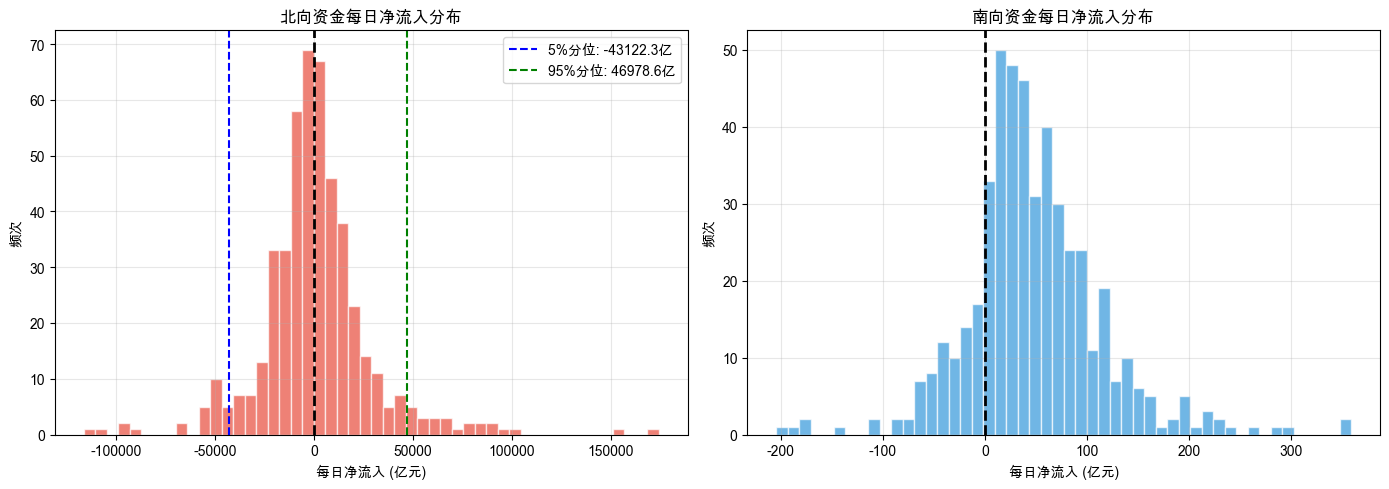

In [ ]:
# =============================================================================
# 2.3 流入/流出极端值分析
# Extreme Values Analysis
# =============================================================================

# 找出北向资金单日净流入最大/最小的10天
north_top10_inflow = df.nlargest(10, 'north_daily')[['trade_date', 'north_daily']]
north_top10_outflow = df.nsmallest(10, 'north_daily')[['trade_date', 'north_daily']]

print("🚀 北向资金单日净流入TOP 10 (外资大幅买入A股的日子):")
display(north_top10_inflow)

print("\n⚠️ 北向资金单日净流出TOP 10 (外资大幅卖出A股的日子):")
display(north_top10_outflow)

# 可视化极端值分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 北向资金每日流入分布直方图
ax1 = axes[0]
ax1.hist(df['north_daily'].dropna(), bins=50, color='#E74C3C', alpha=0.7, edgecolor='white')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax1.set_title('北向资金每日净流入分布')
ax1.set_xlabel('每日净流入 (亿元)')
ax1.set_ylabel('频次')
ax1.grid(True, alpha=0.3)

# 标注极端值阈值
p5 = df['north_daily'].quantile(0.05)
p95 = df['north_daily'].quantile(0.95)
ax1.axvline(x=p5, color='blue', linestyle='--', label=f'5%分位: {p5:.1f}亿')
ax1.axvline(x=p95, color='green', linestyle='--', label=f'95%分位: {p95:.1f}亿')
ax1.legend()

# 南向资金每日流入分布直方图
ax2 = axes[1]
ax2.hist(df['south_daily'].dropna(), bins=50, color='#3498DB', alpha=0.7, edgecolor='white')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_title('南向资金每日净流入分布')
ax2.set_xlabel('每日净流入 (亿元)')
ax2.set_ylabel('频次')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


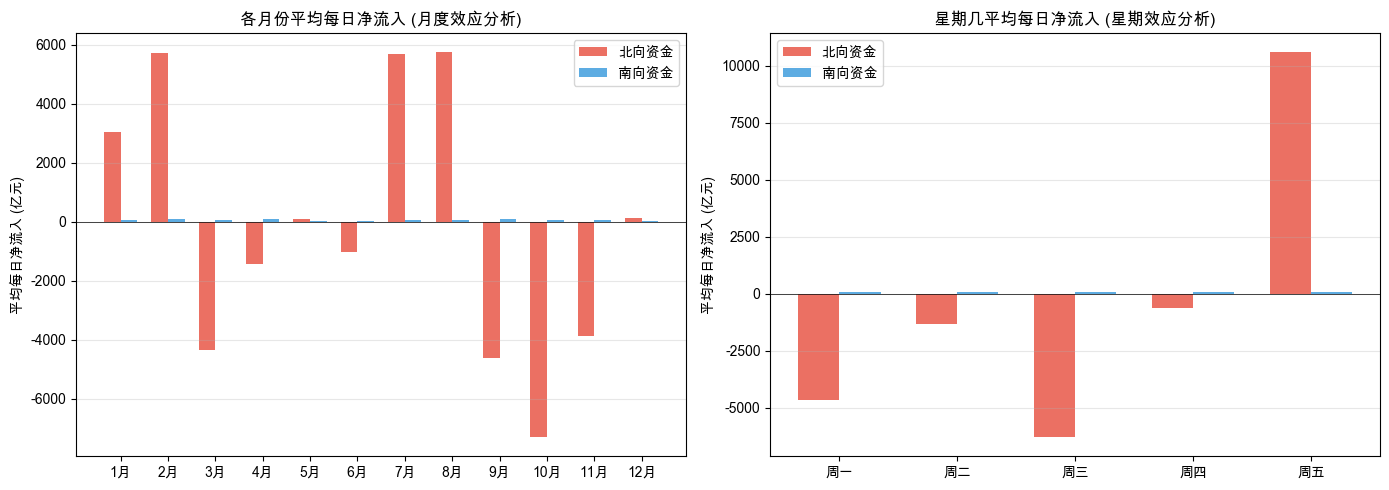

📅 月度效应分析:
   • 外资通常在哪些月份更活跃？观察北向柱状图较高的月份
   • 南向资金是否有明显的季节性？


In [70]:
# =============================================================================
# 2.4 季节/周期维度分析
# Seasonal/Cyclical Patterns
# =============================================================================

# 添加年份和月份列
df['year'] = df['trade_date'].dt.year
df['month'] = df['trade_date'].dt.month
df['quarter'] = df['trade_date'].dt.quarter
df['weekday'] = df['trade_date'].dt.dayofweek  # 0=周一, 4=周五

# 按月份统计平均每日净流入
monthly_avg = df.groupby('month')[['north_daily', 'south_daily']].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 月度模式
ax1 = axes[0]
x = np.arange(12)
width = 0.35
ax1.bar(x - width/2, monthly_avg['north_daily'], width, label='北向资金', color='#E74C3C', alpha=0.8)
ax1.bar(x + width/2, monthly_avg['south_daily'], width, label='南向资金', color='#3498DB', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月'])
ax1.set_title('各月份平均每日净流入 (月度效应分析)')
ax1.set_ylabel('平均每日净流入 (亿元)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linewidth=0.5)

# 星期几模式
weekday_avg = df.groupby('weekday')[['north_daily', 'south_daily']].mean()
ax2 = axes[1]
x = np.arange(5)
ax2.bar(x - width/2, weekday_avg['north_daily'], width, label='北向资金', color='#E74C3C', alpha=0.8)
ax2.bar(x + width/2, weekday_avg['south_daily'], width, label='南向资金', color='#3498DB', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(['周一', '周二', '周三', '周四', '周五'])
ax2.set_title('星期几平均每日净流入 (星期效应分析)')
ax2.set_ylabel('平均每日净流入 (亿元)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("📅 月度效应分析:")
print("   • 外资通常在哪些月份更活跃？观察北向柱状图较高的月份")
print("   • 南向资金是否有明显的季节性？")


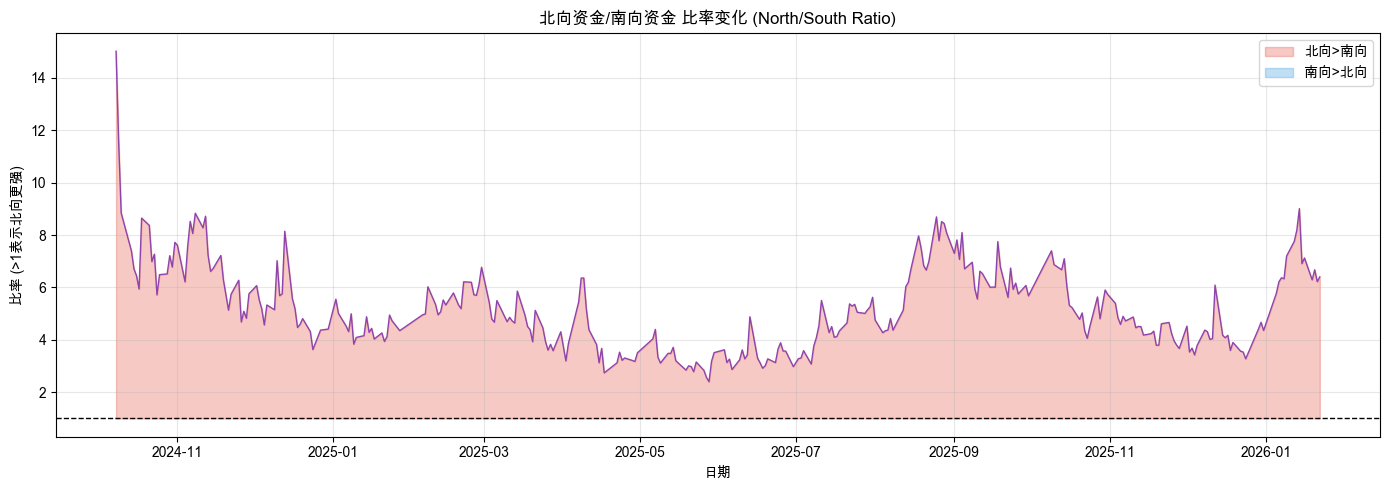

📊 北向/南向比率分析:
   • 最新比率: 6.40
   • 历史均值: 5.17
   • 最高比率: 15.02
   • 最低比率: 2.40


In [71]:
# =============================================================================
# 2.5 南北向资金比率分析
# North/South Ratio Analysis
# =============================================================================

# 计算北向/南向比率 (当南向为0时设为NaN避免除零)
df['ns_ratio'] = df['north_money'] / df['south_money'].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['trade_date'], df['ns_ratio'], color='#8E44AD', linewidth=1)
ax.fill_between(df['trade_date'], 1, df['ns_ratio'], where=df['ns_ratio']>1, 
                alpha=0.3, color='#E74C3C', label='北向>南向')
ax.fill_between(df['trade_date'], 1, df['ns_ratio'], where=df['ns_ratio']<1, 
                alpha=0.3, color='#3498DB', label='南向>北向')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
ax.set_title('北向资金/南向资金 比率变化 (North/South Ratio)')
ax.set_xlabel('日期')
ax.set_ylabel('比率 (>1表示北向更强)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 北向/南向比率分析:")
print(f"   • 最新比率: {df['ns_ratio'].iloc[-1]:.2f}")
print(f"   • 历史均值: {df['ns_ratio'].mean():.2f}")
print(f"   • 最高比率: {df['ns_ratio'].max():.2f}")
print(f"   • 最低比率: {df['ns_ratio'].min():.2f}")


---
# 第三部分: 量化投资者视角分析
## Part 3: Quantitative Investor Perspective


In [72]:
# =============================================================================
# 3.1 统计描述维度
# Statistical Description
# =============================================================================

print("📊 量化统计指标:")
print("=" * 60)

# 计算更多统计量
quant_stats = pd.DataFrame({
    '均值(Mean)': df[['north_daily', 'south_daily']].mean(),
    '标准差(Std)': df[['north_daily', 'south_daily']].std(),
    '偏度(Skewness)': df[['north_daily', 'south_daily']].skew(),
    '峰度(Kurtosis)': df[['north_daily', 'south_daily']].kurtosis(),
    '最小值(Min)': df[['north_daily', 'south_daily']].min(),
    '25%分位': df[['north_daily', 'south_daily']].quantile(0.25),
    '中位数(Median)': df[['north_daily', 'south_daily']].median(),
    '75%分位': df[['north_daily', 'south_daily']].quantile(0.75),
    '最大值(Max)': df[['north_daily', 'south_daily']].max(),
})
display(quant_stats.T)

print("\n💡 解读:")
print("   • 偏度(Skewness): 正值表示右偏(大额流入更多), 负值表示左偏(大额流出更多)")
print("   • 峰度(Kurtosis): 值越大说明极端值越多，尾部风险越大")


📊 量化统计指标:


,north_daily,south_daily
均值(Mean),-581.247240,57.627468
标准差(Std),31312.829224,77.152997
偏度(Skewness),-0.036601,0.292932
峰度(Kurtosis),1.677112,2.191791
最小值(Min),-116647.360000,-204.410000
25%分位,-18210.812500,13.377500
中位数(Median),-745.190000,54.690000
75%分位,16335.772500,96.707500
最大值(Max),103596.570000,358.770000



💡 解读:
   • 偏度(Skewness): 正值表示右偏(大额流入更多), 负值表示左偏(大额流出更多)
   • 峰度(Kurtosis): 值越大说明极端值越多，尾部风险越大


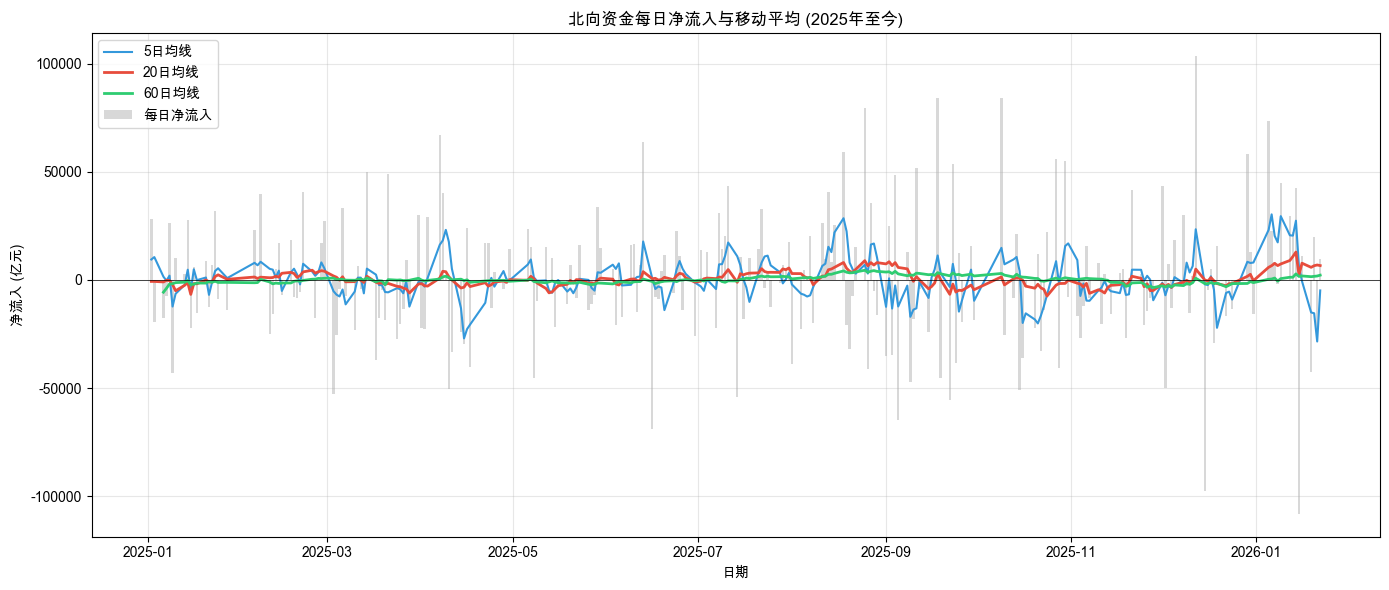

📈 移动平均信号解读:
   • MA5 > MA20: 短期流入动能增强，可能是买入信号
   • MA5 < MA20: 短期流入动能减弱，可能是卖出信号


In [73]:
# =============================================================================
# 3.2 移动平均分析 (技术指标)
# Moving Average Analysis
# =============================================================================

# 计算移动平均
df['north_ma5'] = df['north_daily'].rolling(window=5).mean()   # 5日均线
df['north_ma20'] = df['north_daily'].rolling(window=20).mean() # 20日均线
df['north_ma60'] = df['north_daily'].rolling(window=60).mean() # 60日均线

# 可视化最近一年的数据
recent_df = df[df['trade_date'] >= '2025-01-01'].copy()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(recent_df['trade_date'], recent_df['north_daily'], alpha=0.3, color='gray', label='每日净流入')
ax.plot(recent_df['trade_date'], recent_df['north_ma5'], color='#3498DB', linewidth=1.5, label='5日均线')
ax.plot(recent_df['trade_date'], recent_df['north_ma20'], color='#E74C3C', linewidth=2, label='20日均线')
ax.plot(recent_df['trade_date'], recent_df['north_ma60'], color='#2ECC71', linewidth=2, label='60日均线')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('北向资金每日净流入与移动平均 (2025年至今)')
ax.set_xlabel('日期')
ax.set_ylabel('净流入 (亿元)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 移动平均信号解读:")
print("   • MA5 > MA20: 短期流入动能增强，可能是买入信号")
print("   • MA5 < MA20: 短期流入动能减弱，可能是卖出信号")


In [74]:
# =============================================================================
# 3.3 因子构造 (Factor Construction)
# =============================================================================

# 标准化因子 (Z-Score)
df['north_zscore'] = (df['north_daily'] - df['north_daily'].mean()) / df['north_daily'].std()
df['south_zscore'] = (df['south_daily'] - df['south_daily'].mean()) / df['south_daily'].std()

# 动量因子: 过去N天的累计流入
df['north_momentum_5d'] = df['north_daily'].rolling(5).sum()
df['north_momentum_20d'] = df['north_daily'].rolling(20).sum()

# 波动率因子: 过去20天的标准差
df['north_volatility_20d'] = df['north_daily'].rolling(20).std()

print("✅ 因子构造完成:")
print("   • north_zscore: 北向资金标准化因子")
print("   • north_momentum_5d/20d: 5日/20日动量因子")
print("   • north_volatility_20d: 20日波动率因子")

# 显示因子统计
factor_cols = ['north_zscore', 'north_momentum_5d', 'north_momentum_20d', 'north_volatility_20d']
display(df[factor_cols].describe())


✅ 因子构造完成:
   • north_zscore: 北向资金标准化因子
   • north_momentum_5d/20d: 5日/20日动量因子
   • north_volatility_20d: 20日波动率因子


,north_zscore,north_momentum_5d,north_momentum_20d,north_volatility_20d
count,3.080000e+02,304.000000,289.000000,289.000000
mean,-1.153478e-17,-2.786447,2903.084533,28990.589209
std,1.000000e+00,52285.694432,71134.540854,8131.203974
min,-3.706663e+00,-289379.940000,-210441.960000,14421.313749
25%,-5.630141e-01,-27412.707500,-41129.660000,22144.353590
50%,-5.235642e-03,-1381.395000,-4373.080000,27189.635397
75%,5.402584e-01,27790.010000,38923.280000,37307.050007
max,3.327001e+00,151413.130000,257545.680000,48999.649122


📊 交易信号阈值:
   • 强流入阈值 (90%分位): 34335.81 亿元
   • 强流出阈值 (10%分位): -36223.38 亿元

📈 信号统计:
signal
 0    247
-1     31
 1     31
Name: count, dtype: int64


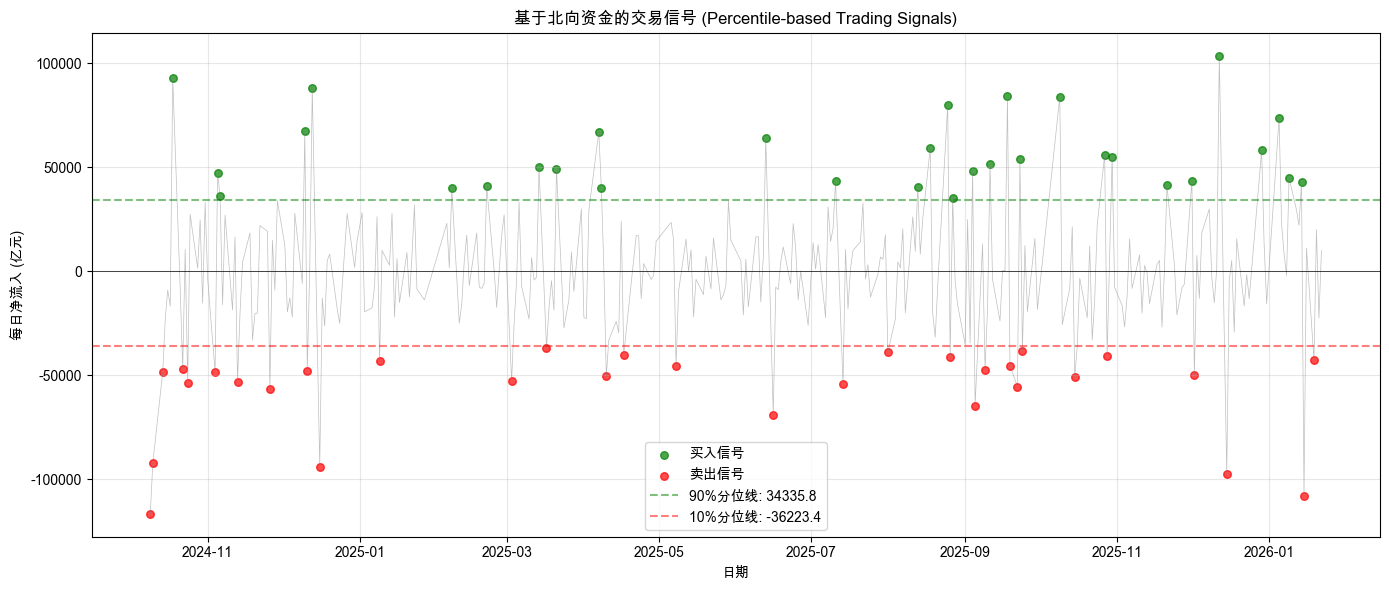

In [75]:
# =============================================================================
# 3.4 极端值阈值与交易信号
# Extreme Values & Trading Signals
# =============================================================================

# 定义阈值
p10 = df['north_daily'].quantile(0.10)  # 10%分位 - 强流出信号
p90 = df['north_daily'].quantile(0.90)  # 90%分位 - 强流入信号

# 生成信号
df['signal'] = 0
df.loc[df['north_daily'] >= p90, 'signal'] = 1   # 买入信号
df.loc[df['north_daily'] <= p10, 'signal'] = -1  # 卖出信号

print(f"📊 交易信号阈值:")
print(f"   • 强流入阈值 (90%分位): {p90:.2f} 亿元")
print(f"   • 强流出阈值 (10%分位): {p10:.2f} 亿元")
print(f"\n📈 信号统计:")
print(df['signal'].value_counts())

# 可视化信号
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['trade_date'], df['north_daily'], color='gray', alpha=0.5, linewidth=0.5)
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
ax.scatter(buy_signals['trade_date'], buy_signals['north_daily'], color='green', s=30, label='买入信号', alpha=0.7)
ax.scatter(sell_signals['trade_date'], sell_signals['north_daily'], color='red', s=30, label='卖出信号', alpha=0.7)
ax.axhline(y=p90, color='green', linestyle='--', alpha=0.5, label=f'90%分位线: {p90:.1f}')
ax.axhline(y=p10, color='red', linestyle='--', alpha=0.5, label=f'10%分位线: {p10:.1f}')
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_title('基于北向资金的交易信号 (Percentile-based Trading Signals)')
ax.set_xlabel('日期')
ax.set_ylabel('每日净流入 (亿元)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 各渠道资金流相关性矩阵:


,hgt_daily,sgt_daily,north_daily,south_daily
hgt_daily,1.000000,0.902711,0.978633,-0.006464
sgt_daily,0.902711,1.000000,0.971888,-0.016536
north_daily,0.978633,0.971888,1.000000,-0.011440
south_daily,-0.006464,-0.016536,-0.011440,1.000000


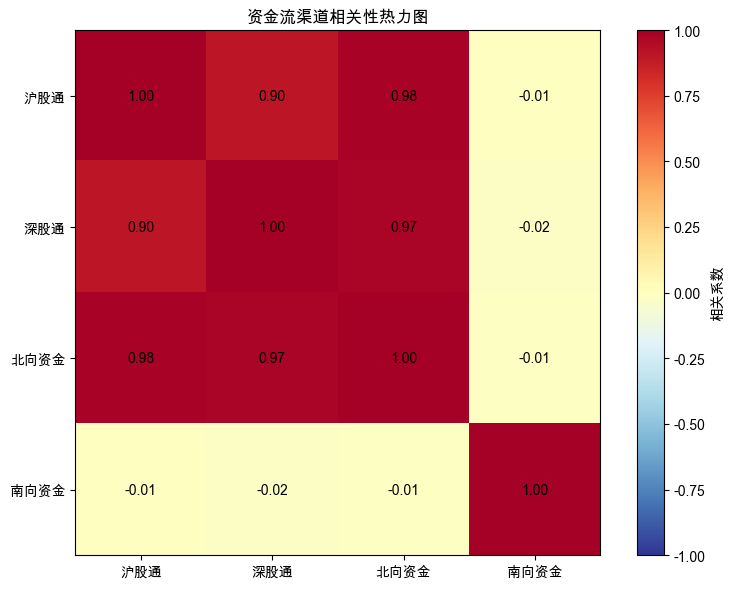


💡 解读:
   • hgt与sgt相关性高说明外资对沪深两市态度一致
   • 北向与南向的相关性可反映两地投资者情绪联动


In [76]:
# =============================================================================
# 3.5 多渠道协方差分析
# Multi-channel Covariance Analysis
# =============================================================================

# 计算各渠道每日流入的相关性矩阵
daily_cols = ['hgt_daily', 'sgt_daily', 'north_daily', 'south_daily']
corr_matrix = df[daily_cols].corr()

print("📊 各渠道资金流相关性矩阵:")
display(corr_matrix)

# 可视化热力图
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(daily_cols)))
ax.set_yticks(range(len(daily_cols)))
labels = ['沪股通', '深股通', '北向资金', '南向资金']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.colorbar(im, label='相关系数')

# 添加数值标注
for i in range(len(daily_cols)):
    for j in range(len(daily_cols)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_title('资金流渠道相关性热力图')
plt.tight_layout()
plt.show()

print("\n💡 解读:")
print("   • hgt与sgt相关性高说明外资对沪深两市态度一致")
print("   • 北向与南向的相关性可反映两地投资者情绪联动")


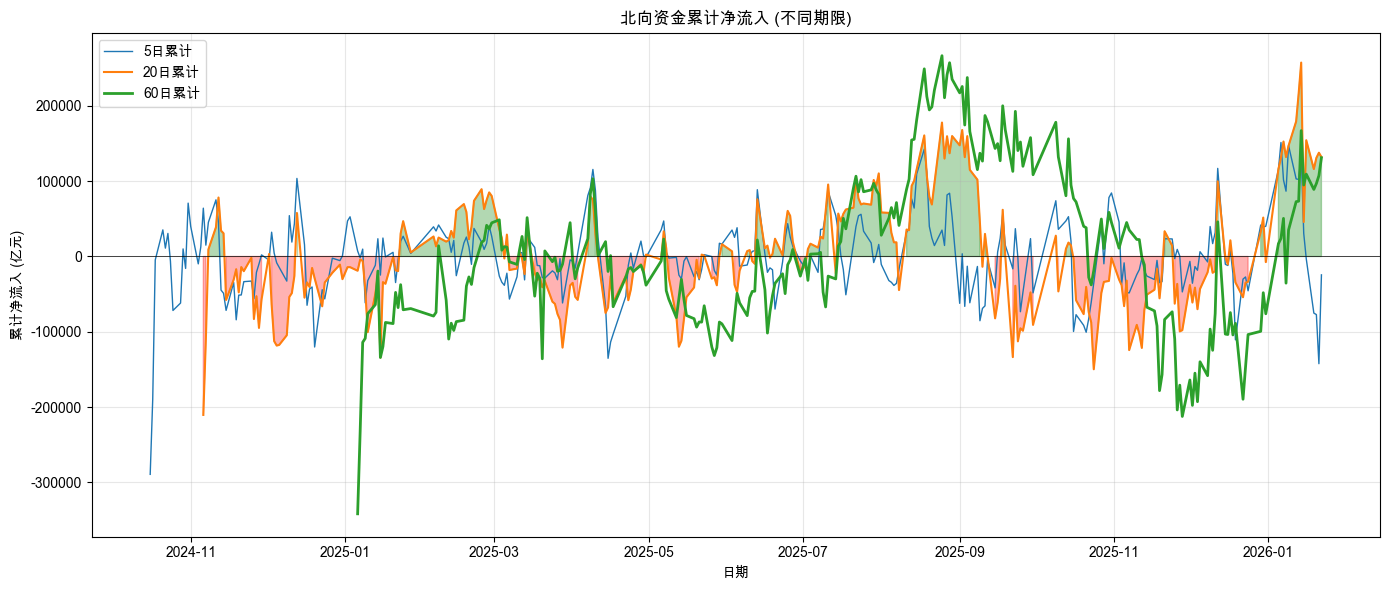

📈 反转信号监控:
   • 最近5日累计: -24400.85 亿元 (流出)
   • 最近20日累计: 132136.60 亿元 (流入)


In [77]:
# =============================================================================
# 3.6 累计流向与反转监控
# Cumulative Flow & Reversal Monitoring
# =============================================================================

# 计算近N天累计净流入
windows = [5, 10, 20, 60]
for w in windows:
    df[f'north_cum_{w}d'] = df['north_daily'].rolling(w).sum()

# 可视化不同期限的累计流入
fig, ax = plt.subplots(figsize=(14, 6))
recent = df[df['trade_date'] >= '2024-01-01']
ax.plot(recent['trade_date'], recent['north_cum_5d'], label='5日累计', linewidth=1)
ax.plot(recent['trade_date'], recent['north_cum_20d'], label='20日累计', linewidth=1.5)
ax.plot(recent['trade_date'], recent['north_cum_60d'], label='60日累计', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.fill_between(recent['trade_date'], 0, recent['north_cum_20d'], 
                where=recent['north_cum_20d']>0, alpha=0.3, color='green')
ax.fill_between(recent['trade_date'], 0, recent['north_cum_20d'], 
                where=recent['north_cum_20d']<0, alpha=0.3, color='red')
ax.set_title('北向资金累计净流入 (不同期限)')
ax.set_xlabel('日期')
ax.set_ylabel('累计净流入 (亿元)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 反转信号监控:")
latest_5d = df['north_cum_5d'].iloc[-1]
latest_20d = df['north_cum_20d'].iloc[-1]
print(f"   • 最近5日累计: {latest_5d:.2f} 亿元 ({'流入' if latest_5d > 0 else '流出'})")
print(f"   • 最近20日累计: {latest_20d:.2f} 亿元 ({'流入' if latest_20d > 0 else '流出'})")


---
# 第五部分: 分段对比分析 (924前后)
## Part 5: Segmented Comparison Analysis (Before/After 924)


In [78]:
# =============================================================================
# 5.1 924前后统计对比
# Before/After 924 Statistical Comparison
# =============================================================================

# 先确保分段数据集有每日流入数据
df_before_924['north_daily'] = df_before_924['north_money'].diff()
df_before_924['south_daily'] = df_before_924['south_money'].diff() 
df_after_924['north_daily'] = df_after_924['north_money'].diff()
df_after_924['south_daily'] = df_after_924['south_money'].diff()

# 计算两个时期的统计量
before_stats = df_before_924['north_daily'].dropna().agg(['mean', 'std', 'min', 'max', 'median'])
after_stats = df_after_924['north_daily'].dropna().agg(['mean', 'std', 'min', 'max', 'median'])

comparison_df = pd.DataFrame({
    '924之前': before_stats,
    '924之后': after_stats,
    '变化倍数': after_stats / before_stats.replace(0, np.nan)
})
comparison_df.index = ['均值(亿)', '标准差(亿)', '最小值(亿)', '最大值(亿)', '中位数(亿)']

print("📊 924前后北向资金统计对比:")
print("=" * 70)
display(comparison_df.round(2))

print(f"""
💡 关键发现:
   • 日均流入: 924前 {before_stats['mean']:.1f}亿 → 924后 {after_stats['mean']:.1f}亿 (变化 {after_stats['mean']/before_stats['mean']:.1f}倍)
   • 波动率: 924前 {before_stats['std']:.1f}亿 → 924后 {after_stats['std']:.1f}亿 (增幅 {(after_stats['std']/before_stats['std']-1)*100:.0f}%)
   • 极端流出: 924前最大流出 {before_stats['min']:.0f}亿 → 924后 {after_stats['min']:.0f}亿
   • 极端流入: 924前最大流入 {before_stats['max']:.0f}亿 → 924后 {after_stats['max']:.0f}亿
""")


📊 924前后北向资金统计对比:


,924之前,924之后,变化倍数
均值(亿),NaN,-581.25,NaN
标准差(亿),NaN,31312.83,NaN
最小值(亿),NaN,-116647.36,NaN
最大值(亿),NaN,103596.57,NaN
中位数(亿),NaN,-745.19,NaN



💡 关键发现:
   • 日均流入: 924前 nan亿 → 924后 -581.2亿 (变化 nan倍)
   • 波动率: 924前 nan亿 → 924后 31312.8亿 (增幅 nan%)
   • 极端流出: 924前最大流出 nan亿 → 924后 -116647亿
   • 极端流入: 924前最大流入 nan亿 → 924后 103597亿



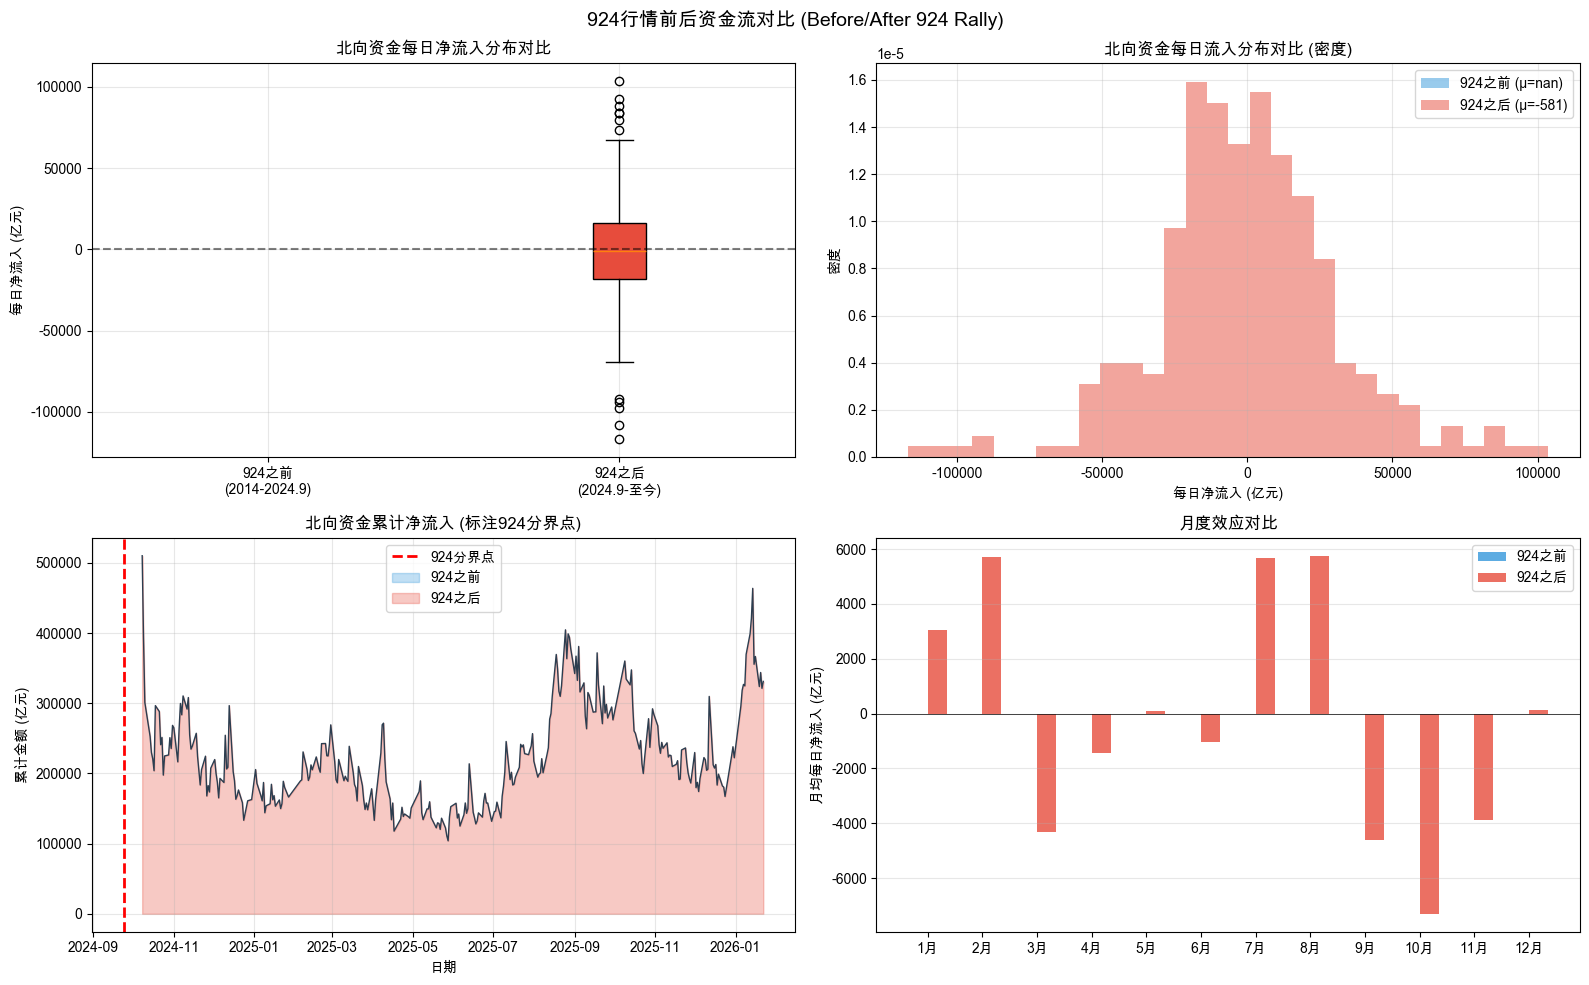

In [79]:
# =============================================================================
# 5.2 分段可视化对比
# Segmented Visualization Comparison  
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('924行情前后资金流对比 (Before/After 924 Rally)', fontsize=14, fontweight='bold')

# 1. 北向资金每日流入对比 (箱线图)
ax1 = axes[0, 0]
box_data = [df_before_924['north_daily'].dropna(), df_after_924['north_daily'].dropna()]
bp = ax1.boxplot(box_data, labels=['924之前\n(2014-2024.9)', '924之后\n(2024.9-至今)'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498DB')
bp['boxes'][1].set_facecolor('#E74C3C')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('北向资金每日净流入分布对比')
ax1.set_ylabel('每日净流入 (亿元)')
ax1.grid(True, alpha=0.3)

# 2. 分布对比 (直方图叠加)
ax2 = axes[0, 1]
ax2.hist(df_before_924['north_daily'].dropna(), bins=50, alpha=0.5, color='#3498DB', 
         label=f'924之前 (μ={before_stats["mean"]:.0f})', density=True)
ax2.hist(df_after_924['north_daily'].dropna(), bins=30, alpha=0.5, color='#E74C3C', 
         label=f'924之后 (μ={after_stats["mean"]:.0f})', density=True)
ax2.set_title('北向资金每日流入分布对比 (密度)')
ax2.set_xlabel('每日净流入 (亿元)')
ax2.set_ylabel('密度')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 累计走势对比 (标注分界点)
ax3 = axes[1, 0]
ax3.plot(df['trade_date'], df['north_money'], color='#2C3E50', linewidth=1)
ax3.axvline(x=BREAKPOINT_DATE, color='red', linestyle='--', linewidth=2, label='924分界点')
ax3.fill_between(df['trade_date'], 0, df['north_money'], 
                 where=df['trade_date'] < BREAKPOINT_DATE, alpha=0.3, color='#3498DB', label='924之前')
ax3.fill_between(df['trade_date'], 0, df['north_money'], 
                 where=df['trade_date'] >= BREAKPOINT_DATE, alpha=0.3, color='#E74C3C', label='924之后')
ax3.set_title('北向资金累计净流入 (标注924分界点)')
ax3.set_xlabel('日期')
ax3.set_ylabel('累计金额 (亿元)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 月度效应对比
ax4 = axes[1, 1]
df_before_924['month'] = df_before_924['trade_date'].dt.month
df_after_924['month'] = df_after_924['trade_date'].dt.month
before_monthly = df_before_924.groupby('month')['north_daily'].mean()
after_monthly = df_after_924.groupby('month')['north_daily'].mean()

x = np.arange(12)
width = 0.35
ax4.bar(x - width/2, before_monthly.reindex(range(1,13)).fillna(0), width, 
        label='924之前', color='#3498DB', alpha=0.8)
ax4.bar(x + width/2, after_monthly.reindex(range(1,13)).fillna(0), width, 
        label='924之后', color='#E74C3C', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月'])
ax4.set_title('月度效应对比')
ax4.set_ylabel('月均每日净流入 (亿元)')
ax4.legend()
ax4.axhline(y=0, color='black', linewidth=0.5)
ax4.grid(True, alpha=0.3,axis='y')

plt.tight_layout()
plt.show()


In [80]:
# =============================================================================
# 5.3 924前后量化指标对比
# Quantitative Metrics Comparison
# =============================================================================

# 计算分段指标
def calc_quant_metrics(data, col='north_daily'):
    daily = data[col].dropna()
    return {
        '均值': daily.mean(),
        '标准差': daily.std(),
        '偏度': daily.skew(),
        '峰度': daily.kurtosis(),
        '日胜率(流入天数%)': (daily > 0).mean() * 100,
        '90%分位阈值': daily.quantile(0.90),
        '10%分位阈值': daily.quantile(0.10),
        '最大回撤日': daily.min(),
        '最大流入日': daily.max(),
    }

before_metrics = calc_quant_metrics(df_before_924)
after_metrics = calc_quant_metrics(df_after_924)

quant_comparison = pd.DataFrame({
    '924之前': before_metrics,
    '924之后': after_metrics,
})
print("📊 量化指标分段对比:")
display(quant_comparison.round(2))

print("""
⚠️ 量化策略调整建议:
   1. 阈值调整: 924后波动率大幅增加，交易信号阈值需要重新校准
   2. 因子权重: 924后北向资金对市场的影响可能需要重新评估
   3. 风控参数: 924后极端波动更频繁，止损线需要适当放宽
""")


📊 量化指标分段对比:


,924之前,924之后
均值,NaN,-581.25
标准差,NaN,31312.83
偏度,NaN,-0.04
峰度,NaN,1.68
日胜率(流入天数%),NaN,49.03
90%分位阈值,NaN,34335.81
10%分位阈值,NaN,-36223.38
最大回撤日,NaN,-116647.36
最大流入日,NaN,103596.57



⚠️ 量化策略调整建议:
   1. 阈值调整: 924后波动率大幅增加，交易信号阈值需要重新校准
   2. 因子权重: 924后北向资金对市场的影响可能需要重新评估
   3. 风控参数: 924后极端波动更频繁，止损线需要适当放宽



---
# 第六部分: 综合总结
## Part 6: Summary


In [81]:
# =============================================================================
# 综合分析总结
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         沪深港通资金流向分析总结                              ║
║                     Stock Connect Money Flow Summary                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
""")

print("【A股投资者视角关键发现】")
print(f"  1. 长期趋势: 北向资金累计净流入 {df['north_money'].iloc[-1]:.0f} 亿元，持续看好A股")
print(f"  2. 近期动态: 最近5日累计{'净流入' if latest_5d > 0 else '净流出'} {abs(latest_5d):.0f} 亿元")
print(f"  3. 极端行情: 历史最大单日流入 {df['north_daily'].max():.0f} 亿元，最大流出 {df['north_daily'].min():.0f} 亿元")
print(f"  4. 月度特征: 可关注月度均值图识别外资季节性偏好")

print("\n【量化投资者视角关键发现】")
print(f"  1. 统计特征: 北向日均流入 {df['north_daily'].mean():.2f} 亿，波动率 {df['north_daily'].std():.2f} 亿")
print(f"  2. 分布特征: 偏度 {df['north_daily'].skew():.2f}, 峰度 {df['north_daily'].kurtosis():.2f}")
print(f"  3. 交易阈值: 90%分位 {p90:.0f} 亿 (买入信号), 10%分位 {p10:.0f} 亿 (卖出信号)")
print(f"  4. 因子相关: 沪深股通相关系数 {corr_matrix.loc['hgt_daily', 'sgt_daily']:.2f}")

print("\n【⚡924行情分段对比发现】")
print(f"  1. 结构性突变: 924后日均流入从 {before_stats['mean']:.0f}亿 跃升至 {after_stats['mean']:.0f}亿")
print(f"  2. 波动率剧增: 标准差从 {before_stats['std']:.0f}亿 增至 {after_stats['std']:.0f}亿 (增幅{(after_stats['std']/before_stats['std']-1)*100:.0f}%)")
print(f"  3. 极端行情频发: 924后出现多次>5万亿的大额流入/流出日")

print("""
╠══════════════════════════════════════════════════════════════════════════════╣
║                              风险提示                                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  • 北向资金并非万能指标，需结合其他因素综合判断                               ║
║  • 简单的阈值策略可能存在过拟合，实盘需要更严格的回测                          ║
║  • 数据为累计值衍生的每日差分，可能存在数据质量问题                            ║
║  • ⚠️ 924后市场进入新阶段，历史数据参考价值需审慎评估                          ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("✅ 分析完成！Analysis Complete!")



╔══════════════════════════════════════════════════════════════════════════════╗
║                         沪深港通资金流向分析总结                              ║
║                     Stock Connect Money Flow Summary                         ║
╠══════════════════════════════════════════════════════════════════════════════╣

【A股投资者视角关键发现】
  1. 长期趋势: 北向资金累计净流入 331077 亿元，持续看好A股
  2. 近期动态: 最近5日累计净流出 24401 亿元
  3. 极端行情: 历史最大单日流入 103597 亿元，最大流出 -116647 亿元
  4. 月度特征: 可关注月度均值图识别外资季节性偏好

【量化投资者视角关键发现】
  1. 统计特征: 北向日均流入 -581.25 亿，波动率 31312.83 亿
  2. 分布特征: 偏度 -0.04, 峰度 1.68
  3. 交易阈值: 90%分位 34336 亿 (买入信号), 10%分位 -36223 亿 (卖出信号)
  4. 因子相关: 沪深股通相关系数 0.90

【⚡924行情分段对比发现】
  1. 结构性突变: 924后日均流入从 nan亿 跃升至 -581亿
  2. 波动率剧增: 标准差从 nan亿 增至 31313亿 (增幅nan%)
  3. 极端行情频发: 924后出现多次>5万亿的大额流入/流出日

╠══════════════════════════════════════════════════════════════════════════════╣
║                              风险提示                                        ║
╠════════════════════════════════════════════════════════════════════════